In [4]:
import numpy as np
from matplotlib import pyplot as plt

### Funkcije

In [5]:
def rk4( f, x0, t ):
    """Fourth-order Runge-Kutta method to solve x' = f(x,t) with x(t[0]) = x0.

    USAGE:
        x = rk4(f, x0, t)

    INPUT:
        f     - function of x and t equal to dx/dt.  x may be multivalued,
                in which case it should a list or a NumPy array.  In this
                case f must return a NumPy array with the same dimension
                as x.
        x0    - the initial condition(s).  Specifies the value of x when
                t = t[0].  Can be either a scalar or a list or NumPy array
                if a system of equations is being solved.
        t     - list or NumPy array of t values to compute solution at.
                t[0] is the the initial condition point, and the difference
                h=t[i+1]-t[i] determines the step size h.

    OUTPUT:
        x     - NumPy array containing solution values corresponding to each
                entry in t array.  If a system is being solved, x will be
                an array of arrays.
    """

    n = len( t )
    x = np.array( [ x0 ] * n )
    for i in range( n - 1 ):
        h = t[i+1] - t[i]
        k1 = h * f( x[i], t[i] )
        k2 = h * f( x[i] + 0.5 * k1, t[i] + 0.5 * h )
        k3 = h * f( x[i] + 0.5 * k2, t[i] + 0.5 * h )
        k4 = h * f( x[i] + k3, t[i+1] )
        x[i+1] = x[i] + ( k1 + 2.0 * ( k2 + k3 ) + k4 ) / 6.0

    return x

def shoot( f, a, b, z1, z2, t, tol ):
    """Implements the shooting method to solve second order BVPs

    USAGE:
        y = shoot(f, a, b, z1, z2, t, tol)

    INPUT:
        f     - function dy/dt = f(y,t).  Since we are solving a second-
                order boundary-value problem that has been transformed
                into a first order system, this function should return a
                1x2 array with the first entry equal to y and the second
                entry equal to y'.
        a     - solution value at the left boundary: a = y(t[0]).
        b     - solution value at the right boundary: b = y(t[n-1]).
        z1    - first initial estimate of y'(t[0]).
        z1    - second initial estimate of y'(t[0]).
        t     - array of n time values to determine y at.
        tol   - allowable tolerance on right boundary: | b - y[n-1] | < tol

    OUTPUT:
        y     - array of solution function values corresponding to the
                values in the supplied array t.

    NOTE:
        This function assumes that the second order BVP has been converted to
        a first order system of two equations.  The secant method is used to
        refine the initial values of y' used for the initial value problems.
    """


    max_iter = 25   # Maximum number of shooting iterations

    n = len( t )    # Determine the size of the arrays we will generate

    # Compute solution to first initial value problem (IVP) with y'(a) = z1.
    # Because we are using the secant method to refine our estimates of z =
    # y', we don't really need all the solution of the IVP, just the last
    # point of it -- this is saved in w1.

    y = rk4( f, [a,z1], t )
    w1 = y[n-1,0]

    # Begin the main loop.  We will compute the solution of a second IVP and
    # then use the both solutions to refine our estimate of y'(a).  This
    # second solution then replaces the first and a new "second" solution is
    # generated.  This process continues until we either solve the problem to
    # within the specified tolerance or we exceed the maximum number of
    # allowable iterations.

    for i in range( max_iter ):

        # Solve second initial value problem, using y'(a) = z2.  We need to
        # retain the entire solution vector y since if y(t(n)) is close enough
        # to b for us to stop then the first column of y becomes our solution
        # vector.

        y = rk4( f, [a,z2], t )
        w2 = y[n-1,0]

        # Check to see if we are done...

        if abs( b - w2 ) < tol:
            break

        # Compute the new approximations to the initial value of the first
        # derivative.  We compute z2 using a linear fit through (z1,w1) and
        # (z2,w2) where w1 and w2 are the estimates at t=b of the initial
        # value problems solved above with y1'(a) = z1 and y2'(a) = z2.  The
        # new value for z1 is the old value of z2.

        #z1, z2 = ( z2, z1 + ( z2 - z1 ) / ( w2 - w1 ) * ( b - w1 ) )
        z1, z2 = ( z2, z2 + ( z2 - z1 ) / ( w2 - w1 ) * ( b - w2 ) )
        w1 = w2

    # All done.  Check to see if we really solved the problem, and then return
    # the solution.


    return y[:,0]

def fd( u, v, w, t, a, b ):
    """Implements the finite difference  method to solve linear second order BVPs

    Compute finite difference solution to the BVP

        x'' = u(t) + v(t) x + w(t) x'
        x(t[0]) = a, x(t[n-1]) = b

    t should be passed in as an n element array.   u, v, and w should be
    either n element arrays corresponding to u(t), v(t) and w(t) or
    scalars, in which case an n element array with the given value is
    generated for each of them.

    USAGE:
        x = fd(u, v, w, t, a, b)

    INPUT:
        u,v,w - arrays containing u(t), v(t), and w(t) values.  May be
                specified as Python lists, NumPy arrays, or scalars.  In
                each case they are converted to NumPy arrays.
        t     - array of n time values to determine x at
        a     - solution value at the left boundary: a = x(t[0])
        b     - solution value at the right boundary: b = x(t[n-1])

    OUTPUT:
        x     - array of solution function values corresponding to the
                values in the supplied array t.
    """

    # Get the dimension of t and make sure that t is an n-element vector

    if type( t ) != np.ndarray:
        if type( t ) == list:
            t = np.array( t )
        else:
            t = np.array( [ float( t ) ] )

    n = len( t )

    # Make sure that u, v, and w are either scalars or n-element vectors.
    # If they are scalars then we create vectors with the scalar value in
    # each position.

    if type( u ) == int or type( u ) == float:
        u = np.array( [ float( u ) ] * n )

    if type( v ) == int or type( v ) == float:
        v = np.array( [ float( v ) ] * n )

    if type( w ) == int or type( w ) == float:
        w = np.array( [ float( w ) ] * n )

    # Compute the stepsize.  It is assumed that all elements in t are
    # equally spaced.

    h = t[1] - t[0];

    # Construct tridiagonal system; boundary conditions appear as first and
    # last equations in system.

    A = -( 1.0 + w[1:n] * h / 2.0 )
    A[-1] = 0.0

    C = -( 1.0 - w[0:n-1] * h / 2.0 )
    C[0] = 0.0

    D = 2.0 + h * h * v
    D[0] = D[n-1] = 1.0

    B = - h * h * u
    B[0] = a
    B[n-1] = b

    # Solve tridiagonal system

    for i in range( 1, n ):
        xmult = A[i-1] / D[i-1]
        D[i] = D[i] - xmult * C[i-1]
        B[i] = B[i] - xmult * B[i-1]

    x = np.zeros( n )
    x[n-1] = B[n-1] / D[n-1]

    for i in range( n - 2, -1, -1 ):
        x[i] = ( B[i] - C[i] * x[i+1] ) / D[i]

    return x

### Grafi

Preverimo energije neskončne potencialne jame

<ipython-input-6-4122dc61d944>:15: RuntimeWarning: invalid value encountered in divide
  psisNorm = psi0 / (np.sqrt(np.sum(psi0**2)*(b-a)/N))


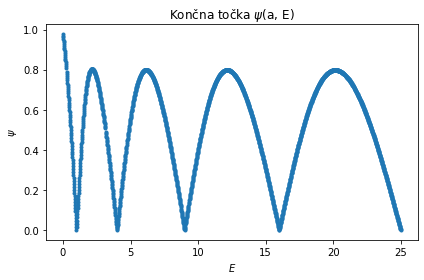

In [6]:
a = 0.0
b = np.pi
N = 200
t = np.linspace( a, b, N )
E_stanj = np.linspace(0, 25.001, 2000)
psi = np.array([])

for E in E_stanj:
    n = np.sqrt(E)

    def f(psi,x):
        return np.array( [psi[1], -E*psi[0]] )

    psi0 = shoot( f, 0., 0., 1, 1.5, t, 1e-5 )
    psisNorm = psi0 / (np.sqrt(np.sum(psi0**2)*(b-a)/N))
    psi = np.append(psi, psisNorm[-1])

plt.title(r'Končna točka $\psi$(a, E)')
plt.plot(E_stanj, psi, '.-', label=r'$\psi$(x=a, E)')
plt.xlabel('$E$')
plt.ylabel(r'$\psi$')
plt.tight_layout()
plt.show()


Lastna funkcija in napake metod računanja

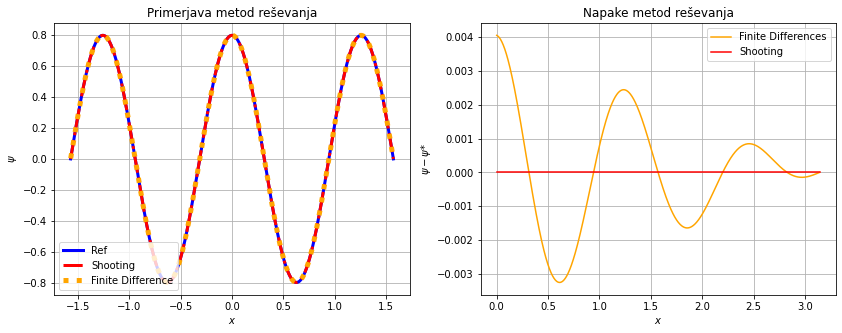

In [7]:
a = 0.0
b = np.pi
N = 1000
t = np.linspace( a, b, N )
n = 5.

def f(psi,x, E=n**2):
    return np.array( [psi[1], -E*psi[0]] )

def anal_resitev(x): #hehe Analitična rešitev
    return np.sqrt(2/np.pi)*np.sin(n*x)

psi = anal_resitev(t)
psi_s1 = shoot( f, 0., 0., n*np.sqrt(2/np.pi), n*np.sqrt(2/np.pi), t, 1e-5 )
fig, ax = plt.subplots( 1, 2, figsize=( 14, 5 ) )
ax[0].plot( t - np.pi/2, psi, color='b', label='Ref', ls='solid', linewidth=3)
ax[0].plot( t - np.pi/2, psi_s1, color='r', label='Shooting', ls='-.',linewidth=3)
a = -np.pi/2
b = np.pi
t1 = np.linspace( a, b, 1500 )
psi_a = anal_resitev( t1 )
psi_fd1 = fd( 0.0, -n**2, 0.0, t1, psi_a[0], psi_a[-1] )
psi_fd1 = psi_fd1[500:1500]
t1 = t1[500:1500]
ax[0].plot( t1-np.pi/2, psi_fd1, color='orange' , label='Finite Difference', ls='dotted',linewidth=5 )
ax[0].set_title( 'Primerjava metod reševanja' )
ax[0].set_xlabel( '$x$' )
ax[0].set_ylabel( r'$\psi$' )
ax[0].legend(loc = 'lower left')
ax[0].grid()
# Plot errors
ax[1].plot( t1, psi_fd1 - psi, color = 'orange', ls = 'solid')
ax[1].plot( t1, psi_s1 - psi, color = 'red', ls = 'solid')
ax[1].set_title( 'Napake metod reševanja' )
ax[1].set_xlabel( '$x$' )
ax[1].set_ylabel( r'$\psi - \psi$*'  )
ax[1].legend(('Finite Differences', 'Shooting' ), loc='upper right')
ax[1].grid()


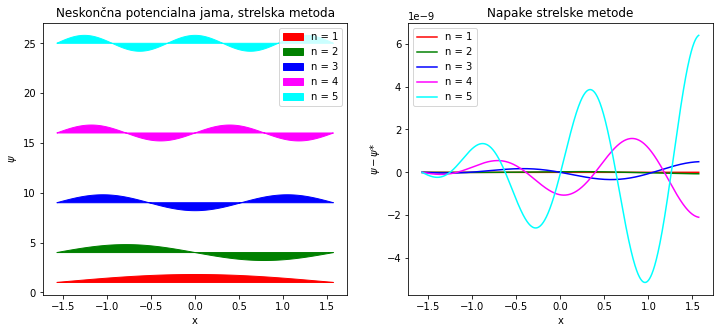

In [8]:
a = 0.0
b = np.pi
N = 1000
t = np.linspace( a, b, N )
# Compute shooting method solutions
stanja = [1, 2, 3, 4, 5]

fig, ax = plt.subplots( 1, 2, figsize=( 12, 5 ) )
plot_colors = ['r', 'g', 'b', 'fuchsia', 'cyan']

for n in stanja:
    
    def f(psi,t, E=n**2):
        return np.array( [psi[1], -E*psi[0]] ) 
    xs1 = shoot( f, 0.0, 0.0, n*np.sqrt(2/np.pi), n*np.sqrt(2/np.pi), t, 1e-5 )
    ax[0].fill( t-np.pi/2, xs1+n**2, color=plot_colors[n-1] )

ax[0].set_title( 'Neskončna potencialna jama, strelska metoda' )
ax[0].set_ylabel( r'$\psi$' )
ax[0].set_xlabel( 'x' )
ax[0].legend( [ 'n = 1', 'n = 2', 'n = 3', 'n = 4', 'n = 5' ], loc = 'best' )
for n in stanja:
    def f(psi,t, E=n**2):
        return np.array( [psi[1], -E*psi[0]] ) 
    xs1 = shoot( f, 0.0, 0.0, n*np.sqrt(2/np.pi), n*np.sqrt(2/np.pi), t, 1e-5 )
    x_analiticna = anal_resitev( t )
    ax[1].plot( t-np.pi/2, xs1-x_analiticna, color=plot_colors[n -1] , ls = 'solid' )
ax[1].set_title( 'Napake strelske metode' )
ax[1].set_ylabel( r'$\psi - \psi$*' )
ax[1].set_xlabel( 'x' )
ax[1].legend( [ 'n = 1', 'n = 2', 'n = 3', 'n = 4', 'n = 5' ] )


<ipython-input-5-7172b84612f7>:108: RuntimeWarning: invalid value encountered in scalar divide
  z1, z2 = ( z2, z2 + ( z2 - z1 ) / ( w2 - w1 ) * ( b - w2 ) )


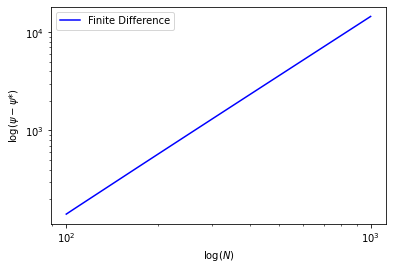

In [9]:
stevilo_korakov = np.arange( 100, 1000 )
napaka_shoot = []
napaka_fd = []
for stevilo in range( 100, 1000 ):
    n = 3.0
    x = np.linspace( 0, np.pi, stevilo )
    psi_shoot = shoot( f, 0., 0., n*np.sqrt(2/np.pi), n*np.sqrt(2/np.pi), x, 1e-5 )
    psi_pravi = anal_resitev( x )
    napaka_shoot.append( np.mean(np.abs(psi_shoot-psi_pravi)) )
for stevilo in range( 100, 1000 ):
    n = 3.0
    x = np.linspace( 0, np.pi, stevilo )
    psi_fd = fd( 0.0, -n**2, 0.0, x, psi_a[0], psi_a[-1] )
    psi_pravi = anal_resitev( x )
    napaka_fd.append( np.mean(np.abs(psi_fd-psi_pravi)) )
#plt.plot(stevilo_korakov, napaka_shoot, 'r', label='Shooting')
plt.plot(stevilo_korakov, napaka_fd, 'b', label='Finite Difference')
plt.legend()
plt.xlabel( r'$\log(N)$' )
plt.ylabel( r'$\log(\psi - \psi$*)' )
plt.yscale( 'log' )
plt.xscale( 'log' )
plt.show()